In [43]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [44]:
'''
# Load the coaches data
coaches = pd.read_csv('./cleaned_data/coaches_agg.csv')

# Function to calculate CER (Coach Efficiency Rating) based on weights
def calculate_CER(weights, df):
    df['CER'] = (
        df['championship'] * weights[0] +
        df['COTY'] * weights[1] +
        df['win_ratio'] * weights[2] +
        df['post_win_ratio'] * weights[3]
    ).round(2)
    return df

# Function to calculate MSE and correlation after optimization
def loss_function(weights, df, model):
    df = calculate_CER(weights, df)
    predictions = model.predict(df[['championship','win_ratio','post_win_ratio','COTY']])
    mse = mean_squared_error(df['CER'], predictions)
    return mse

# Generate multiple sets of random initial weights
n_trials = 10  # number of trials to run
initial_weights_list = [np.random.rand(4) for _ in range(n_trials)]

# Placeholder for best results
best_mse = float('inf')
best_correlation = -float('inf')
best_weights = None
best_model = None

# Initialize initial weights (e.g., equal weights or random weights)
initial_weights = [0.5, 0.38, 0.32, 0.25]  # You can adjust or randomize these

# Calculate CER based on initial weights
coaches = calculate_CER(initial_weights, coaches)

# Split data into train and test sets (80-20 split for example)
X = coaches[['championship', 'win_ratio', 'post_win_ratio', 'COTY']]
y = coaches['CER']

# Split into training and testing sets (80-20 split for example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model (XGBoost as an example)
trained_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
trained_model.fit(X_train, y_train)

# Evaluate each set of initial weights
for i, initial_weights in enumerate(initial_weights_list):
    # Optimize weights using scipy's minimize function
    result = minimize(loss_function, initial_weights, args=(coaches, trained_model), method='Nelder-Mead')
    
    # Get optimized weights
    optimized_weights = result.x
    
    # Calculate CER with optimized weights
    df = calculate_CER(optimized_weights, coaches)
    
    # Evaluate model performance on the test set
    predictions = trained_model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    # Calculate correlation between CER and actual outcome (championship)
    correlation = df['CER'].corr(df['championship'])

    # Print the weights and the performance metrics
    print(f'Trial {i+1}:')
    print(f'Initial Weights: {initial_weights}')
    print(f'Optimized Weights: {optimized_weights}')
    print(f'MSE: {mse}')
    print(f'Correlation: {correlation:.3f}')
    print('')
    
    # Compare and store the best result
    if mse < best_mse and correlation > best_correlation:
        best_mse = mse
        best_correlation = correlation
        best_weights = optimized_weights
        best_model = trained_model

# Print the best results
print(f"Best Optimized Weights: {best_weights}")
print(f"Best MSE: {best_mse}")
print(f"Best Correlation: {best_correlation}")
'''

'\n# Load the coaches data\ncoaches = pd.read_csv(\'./cleaned_data/coaches_agg.csv\')\n\n# Function to calculate CER (Coach Efficiency Rating) based on weights\ndef calculate_CER(weights, df):\n    df[\'CER\'] = (\n        df[\'championship\'] * weights[0] +\n        df[\'COTY\'] * weights[1] +\n        df[\'win_ratio\'] * weights[2] +\n        df[\'post_win_ratio\'] * weights[3]\n    ).round(2)\n    return df\n\n# Function to calculate MSE and correlation after optimization\ndef loss_function(weights, df, model):\n    df = calculate_CER(weights, df)\n    predictions = model.predict(df[[\'championship\',\'win_ratio\',\'post_win_ratio\',\'COTY\']])\n    mse = mean_squared_error(df[\'CER\'], predictions)\n    return mse\n\n# Generate multiple sets of random initial weights\nn_trials = 10  # number of trials to run\ninitial_weights_list = [np.random.rand(4) for _ in range(n_trials)]\n\n# Placeholder for best results\nbest_mse = float(\'inf\')\nbest_correlation = -float(\'inf\')\nbest_weig

In [45]:
'''
# [0.51547979 0.05558138 0.22746621 0.14764771] weights with 0.929558 correlation with winning the championship

# Calculate CER with the best weights
coaches = calculate_CER(best_weights, coaches)

coaches['CER'].hist(bins=30)
plt.title('Distribution of Coach Efficiency Ratings (CER)')
plt.xlabel('Coach Efficiency Rating')
plt.ylabel('Frequency')
plt.show()
'''

"\n# [0.51547979 0.05558138 0.22746621 0.14764771] weights with 0.929558 correlation with winning the championship\n\n# Calculate CER with the best weights\ncoaches = calculate_CER(best_weights, coaches)\n\ncoaches['CER'].hist(bins=30)\nplt.title('Distribution of Coach Efficiency Ratings (CER)')\nplt.xlabel('Coach Efficiency Rating')\nplt.ylabel('Frequency')\nplt.show()\n"

In [46]:
'''
# ============================
# Display Initial Correlation Matrix
# ============================

# Define the features and target variable
features = ['championship', 'win_ratio', 'post_win_ratio', 'COTY']
target = 'CER'

# Calculate and plot the correlation matrix
correlation_matrix = coaches[features + [target]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Coaches Feature Correlation Matrix (Before Selection)')
plt.show()
'''

"\n# ============================\n# Display Initial Correlation Matrix\n# ============================\n\n# Define the features and target variable\nfeatures = ['championship', 'win_ratio', 'post_win_ratio', 'COTY']\ntarget = 'CER'\n\n# Calculate and plot the correlation matrix\ncorrelation_matrix = coaches[features + [target]].corr()\nplt.figure(figsize=(20, 18))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)\nplt.title('Coaches Feature Correlation Matrix (Before Selection)')\nplt.show()\n"

In [47]:
'''
# Calculate Rolling weighted average of CER

# Sort the data by coachID and year to ensure chronological order
coaches = coaches.sort_values(by=['coachID', 'year'])

# Calculate the Exponential Moving Average (EMA) for each coach
coaches['EMA_CER'] = coaches.groupby('coachID')['CER'].transform(lambda x: x.ewm(span=2, adjust=False).mean()).round(3)

# Check the result
print(coaches[['coachID', 'year', 'CER', 'EMA_CER']].head())

# Save the data to a new CSV file
coaches.to_csv('./cleaned_data/coaches_ema.csv', index=False)
'''

"\n# Calculate Rolling weighted average of CER\n\n# Sort the data by coachID and year to ensure chronological order\ncoaches = coaches.sort_values(by=['coachID', 'year'])\n\n# Calculate the Exponential Moving Average (EMA) for each coach\ncoaches['EMA_CER'] = coaches.groupby('coachID')['CER'].transform(lambda x: x.ewm(span=2, adjust=False).mean()).round(3)\n\n# Check the result\nprint(coaches[['coachID', 'year', 'CER', 'EMA_CER']].head())\n\n# Save the data to a new CSV file\ncoaches.to_csv('./cleaned_data/coaches_ema.csv', index=False)\n"

In [48]:
# Load the teams data
dataset = pd.read_csv('./cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'PlayoffProgScore', '3P%', 'FT%',
    'OFFRTG', 'DEFRTG', 'AST RATIO',
    'REB%', 'TOV%', 'PACE', 'AvgPIE_NextYearPlayers'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

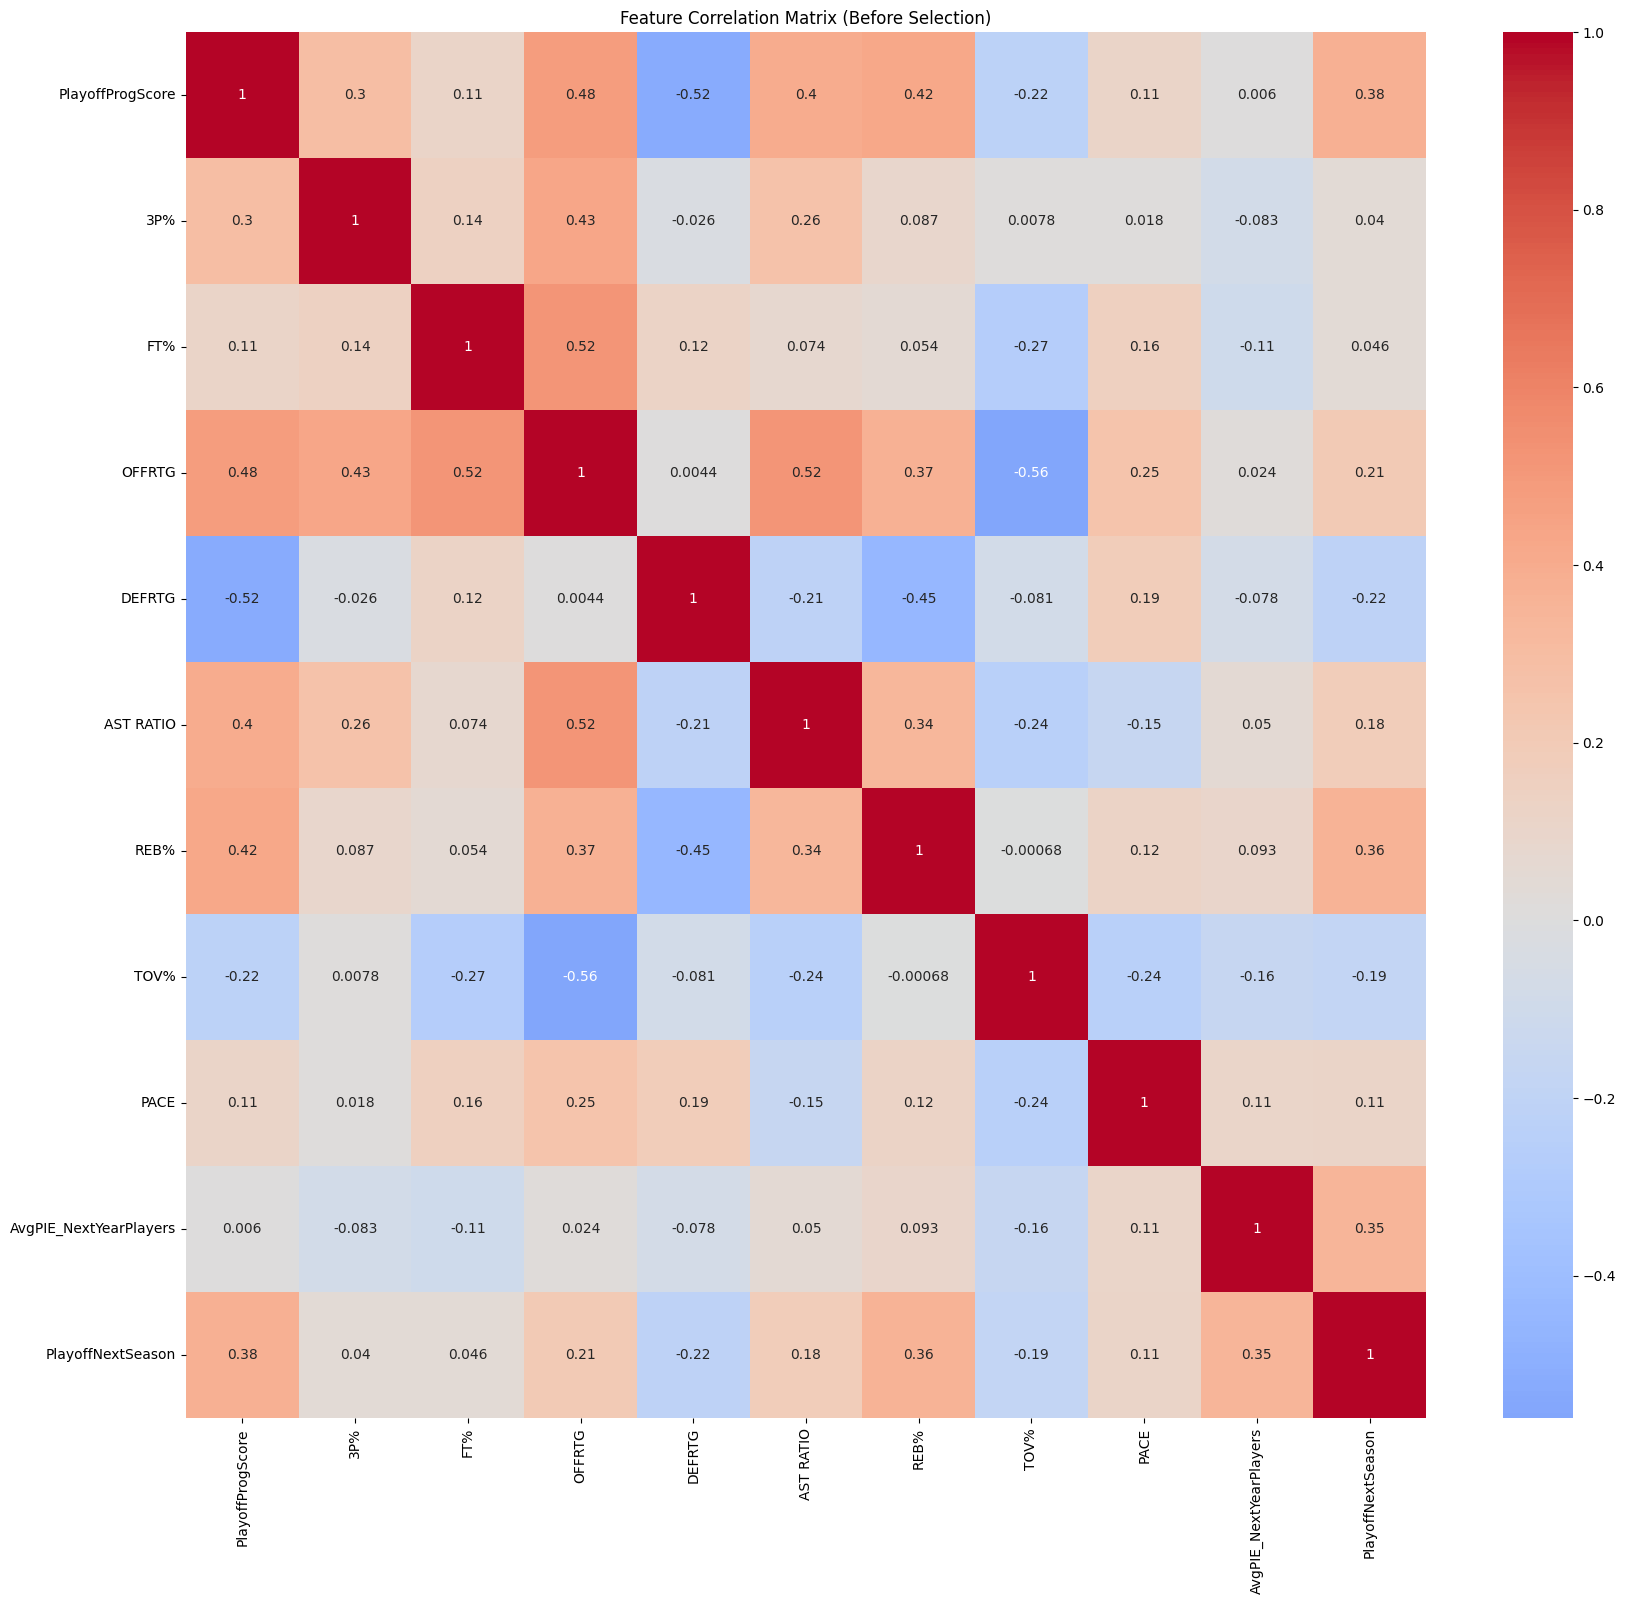

In [49]:
# ============================
# Display Initial Correlation Matrix
# ============================

# Calculate and plot the correlation matrix
correlation_matrix = dataset[features + [label]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Before Selection)')
plt.show()

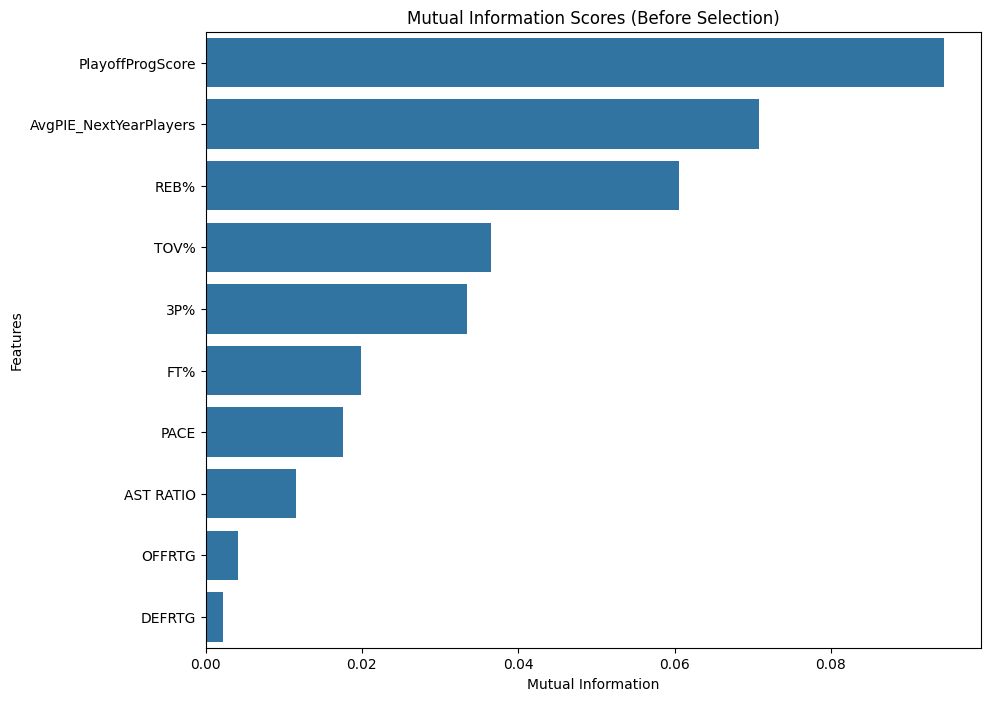

In [50]:
# ============================
# Display Initial Mutual Information Scores
# ============================

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.title('Mutual Information Scores (Before Selection)')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

In [51]:
'''
# ============================
# Correlation Filtering
# ============================

# Calculate the correlation matrix
correlation_matrix = X.corr()
correlation_threshold = 0.9
correlated_features = set()

# Identify features with correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

# Keep only non-correlated features
X = X.drop(columns=correlated_features)
print("Remaining features correlation filtering:", list(X))
'''

'\n# ============================\n# Correlation Filtering\n# ============================\n\n# Calculate the correlation matrix\ncorrelation_matrix = X.corr()\ncorrelation_threshold = 0.9\ncorrelated_features = set()\n\n# Identify features with correlation above the threshold\nfor i in range(len(correlation_matrix.columns)):\n    for j in range(i):\n        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:\n            correlated_features.add(correlation_matrix.columns[i])\n\n# Keep only non-correlated features\nX = X.drop(columns=correlated_features)\nprint("Remaining features correlation filtering:", list(X))\n'

In [52]:
'''
# ============================
# Mutual Information Filtering
# ============================

# Calculate mutual information
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mutual_info_series = pd.Series(mutual_info, index=X.columns)

# Set a threshold for mutual information
mi_threshold = 0.02
selected_features_mi = mutual_info_series[mutual_info_series > mi_threshold].index.tolist()

# Filter the dataset based on selected features
X = X[selected_features_mi]
print("Remaining features after mutual information filtering:", selected_features_mi)
'''

'\n# ============================\n# Mutual Information Filtering\n# ============================\n\n# Calculate mutual information\nmutual_info = mutual_info_classif(X, y, discrete_features=\'auto\', random_state=42)\nmutual_info_series = pd.Series(mutual_info, index=X.columns)\n\n# Set a threshold for mutual information\nmi_threshold = 0.02\nselected_features_mi = mutual_info_series[mutual_info_series > mi_threshold].index.tolist()\n\n# Filter the dataset based on selected features\nX = X[selected_features_mi]\nprint("Remaining features after mutual information filtering:", selected_features_mi)\n'

In [53]:
# ============================
# Define the XGBoost model
# ============================

def create_model(trial):
    return XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 100)
    )

In [54]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

In [55]:
# ============================
# Hyperparameter Tuning with Optuna
# ============================

def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.5 * mean_accuracy + 0.5 * mean_auc

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)
final_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
#final_model = XGBClassifier(
#    learning_rate=0.1,       # Step size shrinkage
#    n_estimators=100,        # Number of trees
#    max_depth=6,             # Maximum depth of trees
#    min_child_weight=1,      # Minimum sum of instance weight (hessian) in a child
#    subsample=0.8,           # Subsample ratio of training data
#    colsample_bytree=0.8,    # Subsample ratio of features per tree
#    gamma=0,                 # Minimum loss reduction to make a split
#    reg_alpha=0,             # L1 regularization
#    reg_lambda=1,            # L2 regularization
#    scale_pos_weight=1,      # Used for imbalanced datasets; adjust if needed
#    random_state=42,         # Ensures reproducibility
#    verbosity=1              # Controls the output verbosity
#)

[I 2024-12-09 22:08:45,081] A new study created in memory with name: no-name-48ecd301-7e60-497b-981e-aa67a34f080c


[I 2024-12-09 22:08:45,573] Trial 0 finished with value: 0.7235204081632653 and parameters: {'learning_rate': 0.16841733046535204, 'n_estimators': 275, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5455712495440291, 'colsample_bytree': 0.6512228470667549, 'gamma': 0.47497098805769744, 'reg_alpha': 0.32661224665181143, 'reg_lambda': 0.98473767363893, 'scale_pos_weight': 84.11960150533531}. Best is trial 0 with value: 0.7235204081632653.
[I 2024-12-09 22:08:45,670] Trial 7 finished with value: 0.7229166666666667 and parameters: {'learning_rate': 0.28743957291493694, 'n_estimators': 127, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5925407818760648, 'colsample_bytree': 0.6540611460235336, 'gamma': 3.327798434757036, 'reg_alpha': 0.382383168750586, 'reg_lambda': 0.25495464545904056, 'scale_pos_weight': 66.19176358757262}. Best is trial 0 with value: 0.7235204081632653.
[I 2024-12-09 22:08:45,676] Trial 1 finished with value: 0.720093537414966 and parameters: {'learning_rat

Best Hyperparameters: {'learning_rate': 0.16640983692081657, 'n_estimators': 70, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9627772663131126, 'colsample_bytree': 0.8328125240505475, 'gamma': 0.13209771833800843, 'reg_alpha': 0.7012278052521271, 'reg_lambda': 0.944583621847628, 'scale_pos_weight': 3.2875411136098283}
Best Value: 0.8051870748299319


,Feature,Average Importance
0,PlayoffProgScore,0.205502
6,REB%,0.158429
9,AvgPIE_NextYearPlayers,0.131375
4,DEFRTG,0.094232
2,FT%,0.088171
8,PACE,0.075246
5,AST RATIO,0.069459
7,TOV%,0.062432
3,OFFRTG,0.062074
1,3P%,0.053080


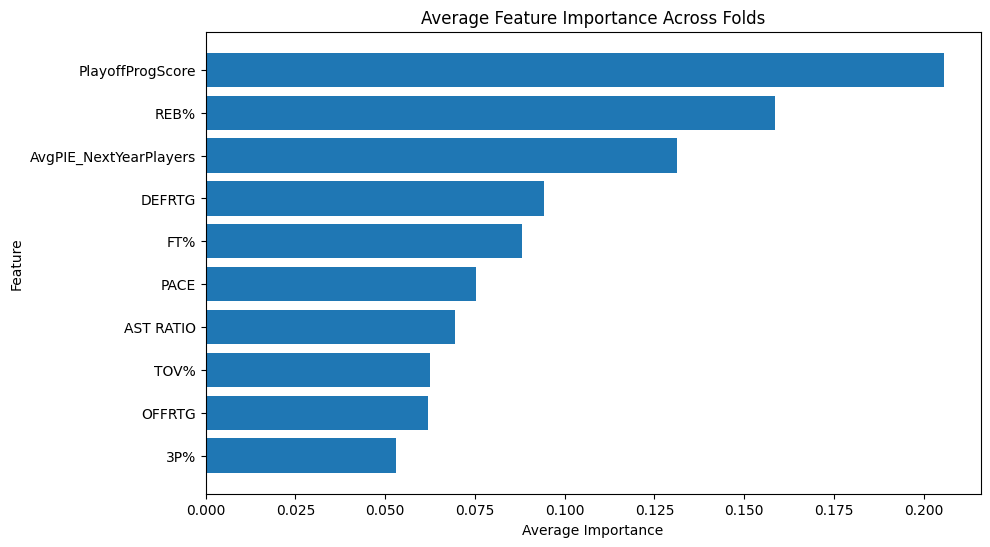

Mean Cross-Validation Accuracy: 0.7976190476190477
Mean Cross-Validation Precision: 0.7586363636363636
Mean Cross-Validation Recall: 0.8875
Mean Cross-Validation F1 Score: 0.8142422799079145
Mean Cross-Validation AUC Score: 0.8127551020408162
Mean Cross-Validation Specificity: 0.7035714285714285


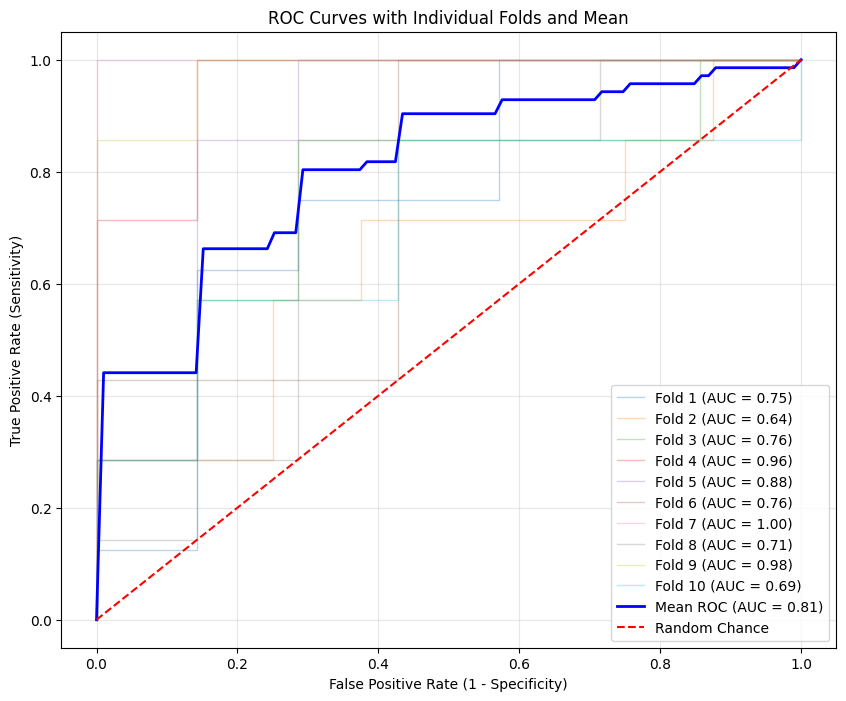

In [56]:
# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

average_importances = np.mean(feature_importances, axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# Display the feature importance table
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()